# Про NumPy и SVD

[Почитать про SVD - 1](http://timbaumann.info/svd-image-compression-demo/)

Сожмите картинку во всех трех каналах с помощью SVD (R,G и B) и оцените, сколько нужно компонент, чтобы получилось вменяемое качество. А сколько мы при этом экономим места?

[Как жать все 3 канала](https://www.kaggle.com/code/paulbacher/practical-applications-to-svd-on-rgb-images/notebook)

In [26]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

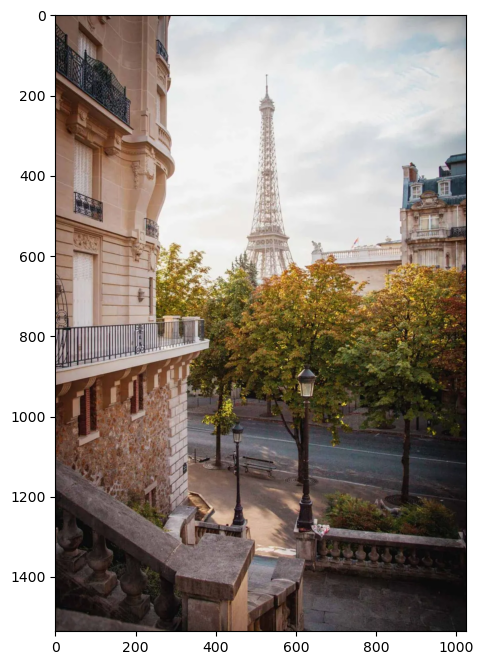

2056.76171875


In [30]:
image_path = 'Avenue-de-Camoens-Paris-Eiffel-Tower.png'
image = Image.open(image_path)
#image = Image.open('Avenue-de-Camoens-Paris-Eiffel-Tower.png')
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.show()

file_size = os.path.getsize(image_path)
print(file_size/1024)

In [21]:
def svd_compressor(image, order):
    """Returns the compressed image channel at the specified order"""
    
    # Create an array filled with zeros having the shape of the image
    compressed = np.zeros(image.shape)
    
    # Get the U, S and V terms (S = SIGMA)
    U, S, V = np.linalg.svd(image)
    
    # Loop over U columns (Ui), S diagonal terms (Si) and V rows (Vi) until the chosen order
    for i in range(order):
        Ui = U[:, i].reshape(-1, 1)
        Vi = V[i, :].reshape(1, -1)
        Si = S[i]
        compressed += (Ui * Si * Vi)
    
    return compressed

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


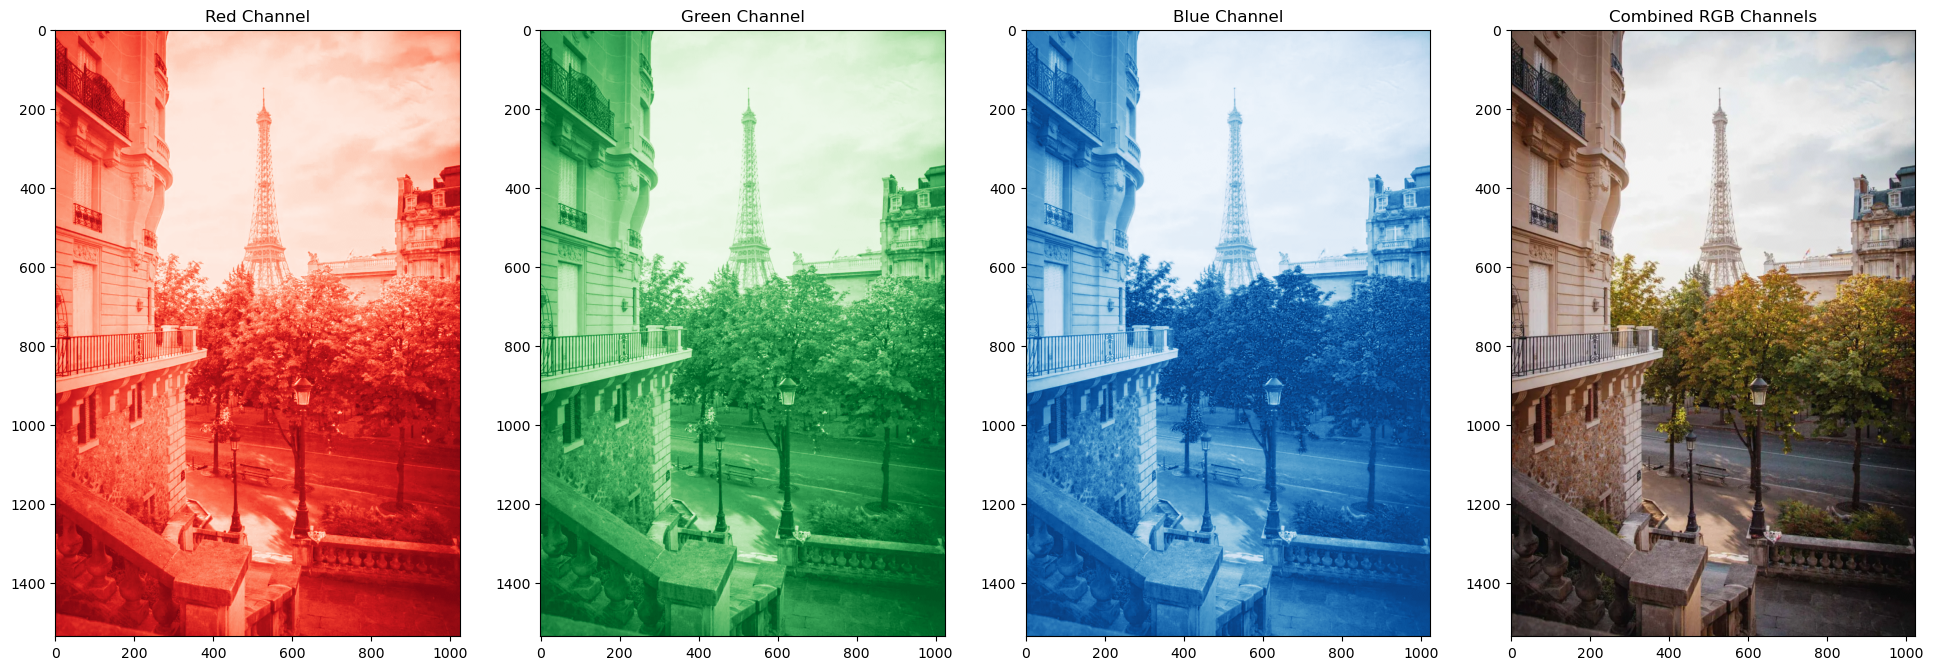

In [23]:
# Separation of the image channels
red_image = np.array(image)[:, :, 0]
green_image = np.array(image)[:, :, 1]
blue_image = np.array(image)[:, :, 2]

# Compression of each channel
order = 500
red_comp = svd_compressor(red_image, order)
green_comp = svd_compressor(green_image, order)
blue_comp = svd_compressor(blue_image, order)

# Recombinasion of the colored image
color_comp = np.zeros((np.array(image).shape[0], np.array(image).shape[1], 3))
color_comp[:, :, 0] = red_comp
color_comp[:, :, 1] = green_comp
color_comp[:, :, 2] = blue_comp
color_comp = np.around(color_comp).astype(int)

# Display of the 3 separated channels
plt.figure(figsize=(24, 8))
plt.subplot(141)
plt.imshow(red_comp, cmap='Reds_r')
plt.title("Red Channel")
plt.subplot(142)
plt.imshow(green_comp, cmap='Greens_r')
plt.title("Green Channel")
plt.subplot(143)
plt.imshow(blue_comp, cmap='Blues_r')
plt.title("Blue Channel")
plt.subplot(144)
plt.imshow(color_comp)
plt.title("Combined RGB Channels")
plt.show()

In [36]:
#смотрим сколько весит картинка
def save_and_get_file_size(image_array, filename):
    image = Image.fromarray(np.uint8(image_array))
    image.save(filename)
    return os.path.getsize(filename)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:49<00:00,  4.91s/it]


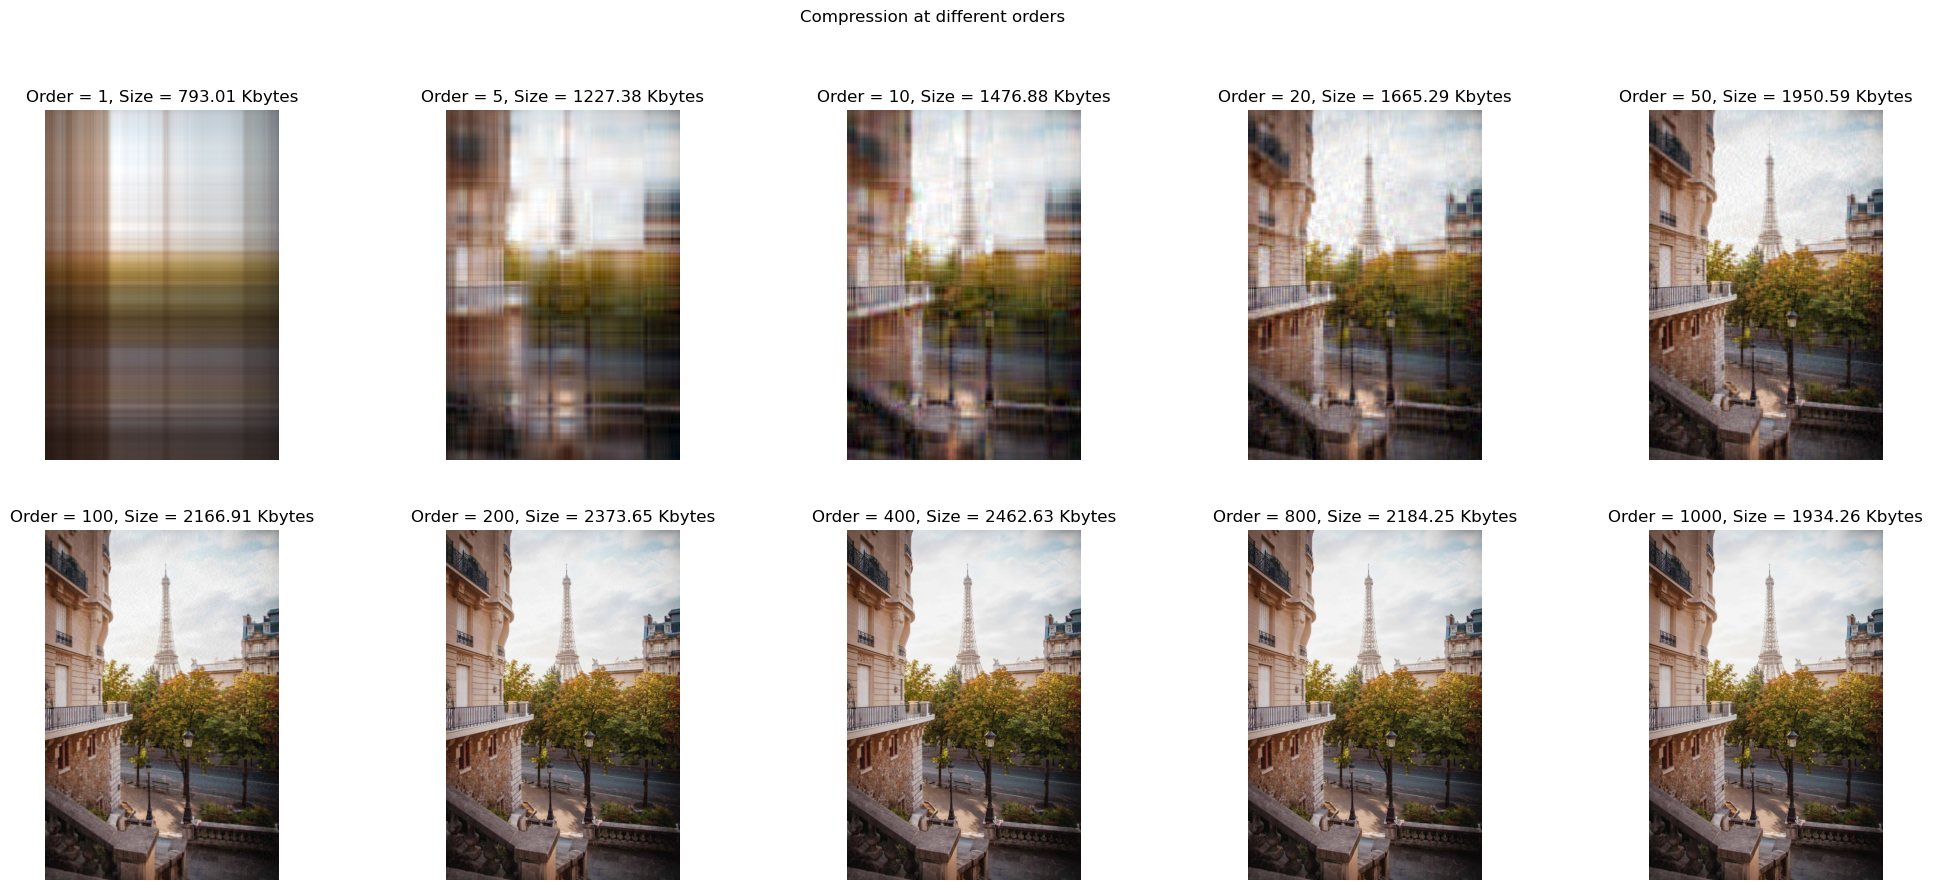

In [39]:
plt.figure(figsize=(25, 10))
orders = [1, 5, 10, 20, 50, 100, 200, 400, 800, 1000]

for i in tqdm(range(len(orders))):
    # Use the compressor function
    order = orders[i]
    red_comp = svd_compressor(red_image, order)
    green_comp = svd_compressor(green_image, order)
    blue_comp = svd_compressor(blue_image, order)
    
    # Combine images
    color_comp = np.zeros((np.array(image).shape[0], np.array(image).shape[1], 3))
    color_comp[:, :, 0] = red_comp
    color_comp[:, :, 1] = green_comp
    color_comp[:, :, 2] = blue_comp
    color_comp = np.around(color_comp).astype(int)
    
    # считаем размер картинки в килобайтах
    compressed_filename = f"compressed_order_{order}.png"
    compressed_size = save_and_get_file_size(color_comp, compressed_filename)

    # Display the compressed colored image in the subplot
    plt.subplot(2, 5, i + 1)
    plt.imshow(color_comp)
    plt.title(f"Order = {order}, Size = {round(compressed_size/1024,2)} Kbytes")
    plt.axis('off')

plt.suptitle('Compression at different orders')
plt.show()

Вывод:

Для хорошего отображения, без особой потери качества нам хватило 100 компонент. 
Но помимо этого мы увидели интересное свойство: сначала чем сильнее мы сжимаем картинку, тем меньше памяти она занимает, но в какой-то момент происходит обратный эффект - небольшое сжатие картинки, наоборот, увеличивает ее вес, так с компонентой 400 картинка весит больше, чем с компонентой 1000.

Это может быть связано с: сложностью изоображения, сжатием с потерями, характера сжатия, цветовой палитры и ее распределения цветов после SVD. Изображение, сжатое на 20 %, может сохранять достаточную сложность, что делает его менее сжимаемым с помощью алгоритма стандартных форматов файлов изображений по сравнению с изображением, сжатым совсем чуть-чуть, которое может быть проще и, следовательно, более эффективно сжиматься и занимать меньше памяти.